# **Part of Speech Tagging using Hidden Markov Models**



In this assignment, you are asked to train your **OWN** Hidden Markov Model to predict part of speech tags of words. Steps to the assignment:
1. Download the data from this link - both the web.conllu and wiki.conllu: https://github.com/google-research-datasets/turkish-treebanks/tree/master/data
1. We combined the web and the wiki to have a bigger dataset. Split this dataset (*sentences*) into train/test sets with 0.8/0.2 proportions. Select a random state number and use it consistently to get the same sets while iterating. **This is very important!**
1. Calculate the transition and emission probabilities using the Maximum Likelihood Estimation (MLE). You can use smoothing for transition and emission probabilities.
1. Train two HMMs with two sets of Part-of-Speech tags.

  a. All of the POS tags in the dataset. There are 14 POS tags in the dataset.

  b. Only the tags "ADJ, ADV, NOUN, VERB, PUNCT"
1. Add the "\<START>" and "\<END>" tags for calculating the induction and ending probabilities.
1. Predict the tags for the test set using Viterbi algorithm with the trained HMM.
1. Evaluate the prediction with the gold labels. Show confusion matrix for the tags.
1. Compare the two versions of the HMMs in terms of accuracy and F1 score - all tags version, only "ADJ, ADV, NOUN, VERB, PUNC" version.
1. Write a small report on your approaches and results.


## Rules
### Allowed:
 - Use any libraries for anything **other than the HMM training and prediction**.
 - Use strategies to increase the performance like handling unknown or rare words, using a dictionary of open/closed words for prediction, changing smoothing functions, and others.
 - Adding additional coding blocks

### Not allowed:
 - **You need to write your own HMM.** Using the HMM model from an external library is not allowed.
 - You should not use others' codes. We will cross check the submissions.

## Assignment Report
Please write a short assignment report at the end of the notebook (max 500 words). Please include all of the following points in the report:
 - Data preparation method
 - How did you calculate of MLE probabilities for transition and emission matrices?
 - Challenges you have faced while writing the HMM model and challenges with the specific dataset
 - Comments about the performance of your HMM tagger
 - Limitations of your approach
 - Possible improvements to the system

## Grading
You will be graded with the following criteria:
 - running complete code (0.25),
 - clear commenting (0.25),
 - data preparation (0.5),
 - HMM transition and emission probability calculation (2)
 - POS tagging the test data with trained HMM using Viterbi algorithm (1.5)
 - Evaluation of the performance of HMM POS tagger (0.5)
 - assignment report (1).

Total points for this assignment = 6


## Submission

Submission will be made to SUCourse. Please submit your file using the following naming convention.


`studentid_studentname_hmm_tagger.ipynb  - ex. 26744_aysegulrana_hmm_tagger.ipynb`


**Deadline is December 8th, 23.55pm.**


In [ ]:
def read_conll(file_path):
    # I created this function to read conllu files
    sentences = []
    sentence = []
    
    # I opened the file here
    file_handle = open(file_path, 'r', encoding='utf-8')
    
    for line in file_handle:
        line = line.strip()
        
        # I skip metadata lines that start with #
        if line.startswith("#"):
            continue
        
        # I check for empty lines to separate sentences
        if line == "":
            if len(sentence) > 0:
                sentences.append(sentence)
                sentence = []
        else:
            # I split the line by tab to get columns
            columns = line.split('\t')
            if len(columns) >= 4:
                word = columns[2]
                # I skip words that are just underscore
                if word != '_':
                    pos_tag = columns[3]
                    word_tag_pair = (word, pos_tag)
                    sentence.append(word_tag_pair)
    
    # I add the last sentence if file doesnt end with blank line (I forgot to check this at first)
    if len(sentence) > 0:
        sentences.append(sentence)
    
    file_handle.close()
    return sentences

# I set the file paths here
web_file_path = "web.conllu"
wiki_file_path = "wiki.conllu"

# I read both files
web_sentences = read_conll(web_file_path)
wiki_sentences = read_conll(wiki_file_path)

# I combine the sentences from both files
sentences = []
for sent in web_sentences:
    sentences.append(sent)
for sent in wiki_sentences:
    sentences.append(sent)

print(f"Total number of sentences: {len(sentences)}")

Total number of sentences: 4851


In [34]:
len(sentences)

4851

## 1. Preprocessing function

In [ ]:
def prepare_data(sentences, tag_list):
    # I createad this function to filter sentences by tag list
    prepared_sentences = []
    
    # I go through evert sentence
    for sentence in sentences:
        filtered_sentence = []
        #  check each word and tag pair
        for word, tag in sentence:
            #  only keep words with tags in the tag_list
            if tag in tag_list:
                filtered_sentence.append((word, tag))
        
        #  just adding non-empty sentences
        if len(filtered_sentence) > 0:
            prepared_sentences.append(filtered_sentence)
    
    return prepared_sentences


## 2. Train test split

In [ ]:
from sklearn.model_selection import train_test_split
import random

#  random state for reproducibility
RANDOM_STATE = 42
random.seed(RANDOM_STATE)

# test and train ratios
test_size_ratio = 0.2
train_size_ratio = 0.8

# I split the data into train and test sets
train_sentences, test_sentences = train_test_split(
    sentences, 
    test_size=test_size_ratio, 
    random_state=RANDOM_STATE
)

# I count the number of sentences in each set
num_train = len(train_sentences)
num_test = len(test_sentences)

print(f"Number of training sentences: {num_train}")
print(f"Number of test sentences: {num_test}")

Number of training sentences: 3880
Number of test sentences: 971


## 3. Model Training

Train your HMM here.

In [ ]:
def create_HMM(train_sentences):
    # I initialize empty dictionaries and sets for counting
    transitions = {}
    emissions = {}
    tag_counts = {}
    vocab = set()
    word_count = 0
    
    #  special tags for start and end of sentences
    START_TAG = "<START>"
    END_TAG = "<END>"
    
    #  go through each sentence in training data
    for sentence in train_sentences:
        if len(sentence) == 0:
            continue
        
        # gott the first word and tag
        first_word, first_tag = sentence[0]
        start_transition_key = (START_TAG, first_tag)
        
        # I count transition from START to first tag
        if start_transition_key in transitions:
            transitions[start_transition_key] = transitions[start_transition_key] + 1
        else:
            transitions[start_transition_key] = 1
        
        prev_tag = first_tag
        
        # I process each word in the sentence
        for word, tag in sentence:
            # I count emissions (tag, word) pairs
            emission_key = (tag, word)
            if emission_key in emissions:
                emissions[emission_key] = emissions[emission_key] + 1
            else:
                emissions[emission_key] = 1
            
            # I count how many times each tag appears
            if tag in tag_counts:
                tag_counts[tag] = tag_counts[tag] + 1
            else:
                tag_counts[tag] = 1
            
            # I add word to vocabulary and count it
            vocab.add(word)
            word_count = word_count + 1
            
            # count transitions betwen consecutive tags
            transition_key = (prev_tag, tag)
            if transition_key in transitions:
                transitions[transition_key] = transitions[transition_key] + 1
            else:
                transitions[transition_key] = 1
            
            prev_tag = tag
        
        # count transition from last tag to END
        last_word, last_tag = sentence[-1]
        end_transition_key = (last_tag, END_TAG)
        if end_transition_key in transitions:
            transitions[end_transition_key] = transitions[end_transition_key] + 1
        else:
            transitions[end_transition_key] = 1
    
    #  setted counts for START and END tags
    tag_counts[START_TAG] = len(train_sentences)
    tag_counts[END_TAG] = len(train_sentences)
    
    return transitions, emissions, tag_counts, vocab, word_count


In [ ]:
# createad the HMM model from training sentences
transitions, emissions, tag_counts, vocab, word_count = create_HMM(train_sentences)

# some statistics about the model
print(f"Number of unique tags: {len(tag_counts)}")
print(f"Tags: {sorted(tag_counts.keys())}")
print(f"Vocabulary size: {len(vocab)}")
print(f"Total word count: {word_count}")

Number of unique tags: 16
Tags: ['<END>', '<START>', 'ADJ', 'ADP', 'ADV', 'AFFIX', 'CONJ', 'DET', 'NOUN', 'NUM', 'ONOM', 'PRON', 'PRT', 'PUNCT', 'VERB', 'X']
Vocabulary size: 8064
Total word count: 53178


## 4. POS tag prediction for test data

Write Viterbi algorithm to predict the POS tags of the test data.

In [ ]:
import numpy as np
import math

def viterbi(test_sentence, transitions, emissions, tag_counts, vocab, word_count):
    # I implement the Viterbi algorithm here for POS tagging
    START_TAG = "<START>"
    END_TAG = "<END>"
    
    # I get all tags except start and end
    all_tags = list(tag_counts.keys())
    tags = []
    for tag in all_tags:
        if tag != START_TAG and tag != END_TAG:
            tags.append(tag)
    tags_sorted = sorted(tags)
    
    n_tags = len(tags_sorted)
    n_words = len(test_sentence)
    
    if n_words == 0:
        return []
    
    # initializeing the Viterbi matrix and back  pointer matrix
    v_matrix = np.full((n_tags, n_words), -np.inf)
    backpointer = np.full((n_tags, n_words), -1, dtype=int)
    
    # I use Laplace smoothing with alpha = 1.0
    alpha = 1.0
    
    # I calculate probabilities for the first word
    first_word = test_sentence[0]
    for i in range(n_tags):
        tag = tags_sorted[i]
        
        # I get transition probability from start to this tag
        transition_key = (START_TAG, tag)
        if transition_key in transitions:
            transition_count = transitions[transition_key]
        else:
            transition_count = 0
        
        if START_TAG in tag_counts:
            start_count = tag_counts[START_TAG]
        else:
            start_count = 1
        
        # appliyed smoothing here
        numerator = transition_count + alpha
        denominator = start_count + alpha * n_tags
        transition_prob = math.log(numerator / denominator)
        
        # get emission probability for this tag and word
        emission_key = (tag, first_word)
        if emission_key in emissions:
            emission_count = emissions[emission_key]
        else:
            emission_count = 0
        
        if tag in tag_counts:
            tag_count = tag_counts[tag]
        else:
            tag_count = 1
        
        # handle dunknown words here 
        if first_word in vocab:
            emission_numerator = emission_count + alpha
        else:
            emission_numerator = alpha
        
        emission_denominator = tag_count + alpha * (word_count + 1)
        emission_prob = math.log(emission_numerator / emission_denominator)
        
        # storeing the initial probability
        v_matrix[i][0] = transition_prob + emission_prob
    
    #  remaining words using Viterbi algorithm
    for word_idx in range(1, n_words):
        word = test_sentence[word_idx]
        
        for curr_tag_idx in range(n_tags):
            curr_tag = tags_sorted[curr_tag_idx]
            best_prob = -np.inf
            best_prev_tag_idx = -1
            
            # checking all possible previous tags
            for prev_tag_idx in range(n_tags):
                prev_tag = tags_sorted[prev_tag_idx]
                prev_prob = v_matrix[prev_tag_idx][word_idx - 1]
                
                if prev_prob == -np.inf:
                    continue
                
                #  calculating transition probability
                transition_key = (prev_tag, curr_tag)
                if transition_key in transitions:
                    transition_count = transitions[transition_key]
                else:
                    transition_count = 0
                
                if prev_tag in tag_counts:
                    prev_tag_count = tag_counts[prev_tag]
                else:
                    prev_tag_count = 1
                
                transition_numerator = transition_count + alpha
                transition_denominator = prev_tag_count + alpha * n_tags
                transition_prob = math.log(transition_numerator / transition_denominator)
                
                # calculatinh emission probability
                emission_key = (curr_tag, word)
                if emission_key in emissions:
                    emission_count = emissions[emission_key]
                else:
                    emission_count = 0
                
                if curr_tag in tag_counts:
                    curr_tag_count = tag_counts[curr_tag]
                else:
                    curr_tag_count = 1
                
                #  handled unknown words again
                if word in vocab:
                    emission_numerator = emission_count + alpha
                else:
                    emission_numerator = alpha
                
                emission_denominator = curr_tag_count + alpha * (word_count + 1)
                emission_prob = math.log(emission_numerator / emission_denominator)
                
                #  calculate total probability
                total_prob = prev_prob + transition_prob + emission_prob
                
                #  keep track of the best path
                if total_prob > best_prob:
                    best_prob = total_prob
                    best_prev_tag_idx = prev_tag_idx
            
            v_matrix[curr_tag_idx][word_idx] = best_prob
            backpointer[curr_tag_idx][word_idx] = best_prev_tag_idx
    
    # I find the best final tag
    best_final_prob = -np.inf
    best_final_tag_idx = -1
    
    for tag_idx in range(n_tags):
        final_prob = v_matrix[tag_idx][n_words - 1]
        tag = tags_sorted[tag_idx]
        
        # I added transition to END tag
        transition_key = (tag, END_TAG)
        if transition_key in transitions:
            transition_count = transitions[transition_key]
        else:
            transition_count = 0
        
        if tag in tag_counts:
            tag_count = tag_counts[tag]
        else:
            tag_count = 1
        
        end_transition_numerator = transition_count + alpha
        end_transition_denominator = tag_count + alpha * n_tags
        end_transition_prob = math.log(end_transition_numerator / end_transition_denominator)
        
        total_final_prob = final_prob + end_transition_prob
        
        if total_final_prob > best_final_prob:
            best_final_prob = total_final_prob
            best_final_tag_idx = tag_idx
    
    #   backtrack to get the best tag sequence
    predicted_tags = []
    current_tag_idx = best_final_tag_idx
    
    for word_idx in range(n_words - 1, -1, -1):
        current_tag = tags_sorted[current_tag_idx]
        predicted_tags.insert(0, current_tag)
        current_tag_idx = backpointer[current_tag_idx][word_idx]
        
        # I handle invalid backpointer
        if current_tag_idx == -1 and word_idx > 0:
            current_tag_idx = np.argmax(v_matrix[:, word_idx - 1])
    
    return predicted_tags

## 5. Evaluate your HMM

Use the test data labels and compare to your prediction. Use the accuracy and F1 score as the performance metrics. Show the confusion matrix for the prediction vs gold labels.


Making predictions on test sentences...
Processed sentences: 100/971
Processed sentences: 200/971
Processed sentences: 300/971
Processed sentences: 400/971
Processed sentences: 500/971
Processed sentences: 600/971
Processed sentences: 700/971
Processed sentences: 800/971
Processed sentences: 900/971

Accuracy: 0.8467
F1 Score (Macro): 0.5956
F1 Score (Weighted): 0.8285


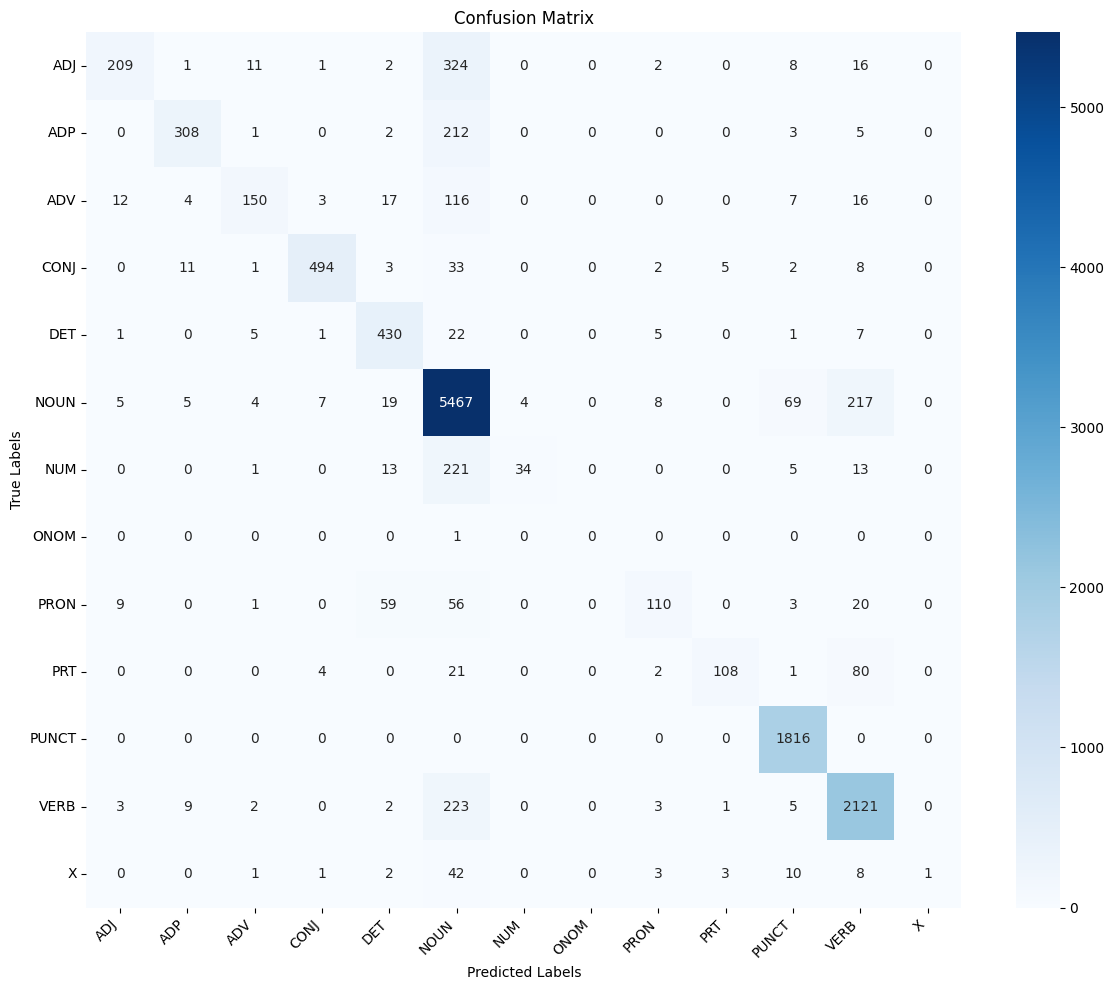


Classification Report:
              precision    recall  f1-score   support

         ADJ       0.87      0.36      0.51       574
         ADP       0.91      0.58      0.71       531
         ADV       0.85      0.46      0.60       325
        CONJ       0.97      0.88      0.92       559
         DET       0.78      0.91      0.84       472
        NOUN       0.81      0.94      0.87      5805
         NUM       0.89      0.12      0.21       287
        ONOM       0.00      0.00      0.00         1
        PRON       0.81      0.43      0.56       258
         PRT       0.92      0.50      0.65       216
       PUNCT       0.94      1.00      0.97      1816
        VERB       0.84      0.90      0.87      2369
           X       1.00      0.01      0.03        71

    accuracy                           0.85     13284
   macro avg       0.82      0.55      0.60     13284
weighted avg       0.85      0.85      0.83     13284



In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(test_sentences, transitions, emissions, tag_counts, vocab, word_count):
    # I initialize lists to store true and predicted tags
    all_true_tags = []
    all_predicted_tags = []
    
    print("Making predictions on test sentences...")
    
    # I go through everty test sentence
    for i in range(len(test_sentences)):
        sentence = test_sentences[i]
        
        if len(sentence) == 0:
            continue
        
        # I separate words and truetags
        words = []
        true_tags = []
        for word, tag in sentence:
            words.append(word)
            true_tags.append(tag)
        
        #  predictin tags using Viterbi algorithm
        predicted_tags = viterbi(words, transitions, emissions, tag_counts, vocab, word_count)
        
        # I make sure lengths match
        min_len = min(len(true_tags), len(predicted_tags))
        
        # collect all tags for evaluation
        for j in range(min_len):
            all_true_tags.append(true_tags[j])
            all_predicted_tags.append(predicted_tags[j])
        
        # I print progress every 100 sentences so I know its working
        if (i + 1) % 100 == 0:
            print(f"Processed sentences: {i + 1}/{len(test_sentences)}")
    
    # I calculate accuracy
    accuracy = accuracy_score(all_true_tags, all_predicted_tags)
    
    # I calculate f1 scores
    f1_macro = f1_score(all_true_tags, all_predicted_tags, average='macro', zero_division=0)
    f1_weighted = f1_score(all_true_tags, all_predicted_tags, average='weighted', zero_division=0)
    
    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"F1 Score (Macro): {f1_macro:.4f}")
    print(f"F1 Score (Weighted): {f1_weighted:.4f}")
    
    # I get all unique tags for confusion matrix
    all_tags_combined = all_true_tags + all_predicted_tags
    unique_tags = sorted(set(all_tags_combined))
    
    # I create confusion matrix
    cm = confusion_matrix(all_true_tags, all_predicted_tags, labels=unique_tags)
    
    # I plot the confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=unique_tags, yticklabels=unique_tags)
    plt.title('Confusion Matrix')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # I print classification report
    print("\nClassification Report:")
    print(classification_report(all_true_tags, all_predicted_tags, zero_division=0))
    
    return accuracy, f1_macro, f1_weighted, all_true_tags, all_predicted_tags

# evaluate the model on test set
accuracy, f1_macro, f1_weighted, true_tags, pred_tags = evaluate_model(
    test_sentences, transitions, emissions, tag_counts, vocab, word_count
)

In [ ]:
# I find all unique tags intraining data
all_tags_in_data = set()

for sentence in train_sentences:
    for word, tag in sentence:
        all_tags_in_data.add(tag)

# print all tags I found
num_tags = len(all_tags_in_data)
print(f"All POS tags in the dataset ({num_tags} tags):")
all_tags_sorted = sorted(all_tags_in_data)
print(all_tags_sorted)

# create two tag lists for comparison
all_tags_list = sorted(all_tags_in_data)
selected_tags_list = ['ADJ', 'ADV', 'NOUN', 'VERB', 'PUNCT']

print(f"\nSelected tags (5 tags): {selected_tags_list}")


All POS tags in the dataset (14 tags):
['ADJ', 'ADP', 'ADV', 'AFFIX', 'CONJ', 'DET', 'NOUN', 'NUM', 'ONOM', 'PRON', 'PRT', 'PUNCT', 'VERB', 'X']

Selected tags (5 tags): ['ADJ', 'ADV', 'NOUN', 'VERB', 'PUNCT']


MODEL 1: MODEL TRAINED WITH ALL TAGS
Number of training sentences (filtered): 3880
Number of test sentences (filtered): 971

Model 1 Evaluation:
------------------------------------------------------------
Making predictions on test sentences...
Processed sentences: 100/971
Processed sentences: 200/971
Processed sentences: 300/971
Processed sentences: 400/971
Processed sentences: 500/971
Processed sentences: 600/971
Processed sentences: 700/971
Processed sentences: 800/971
Processed sentences: 900/971

Accuracy: 0.8467
F1 Score (Macro): 0.5956
F1 Score (Weighted): 0.8285


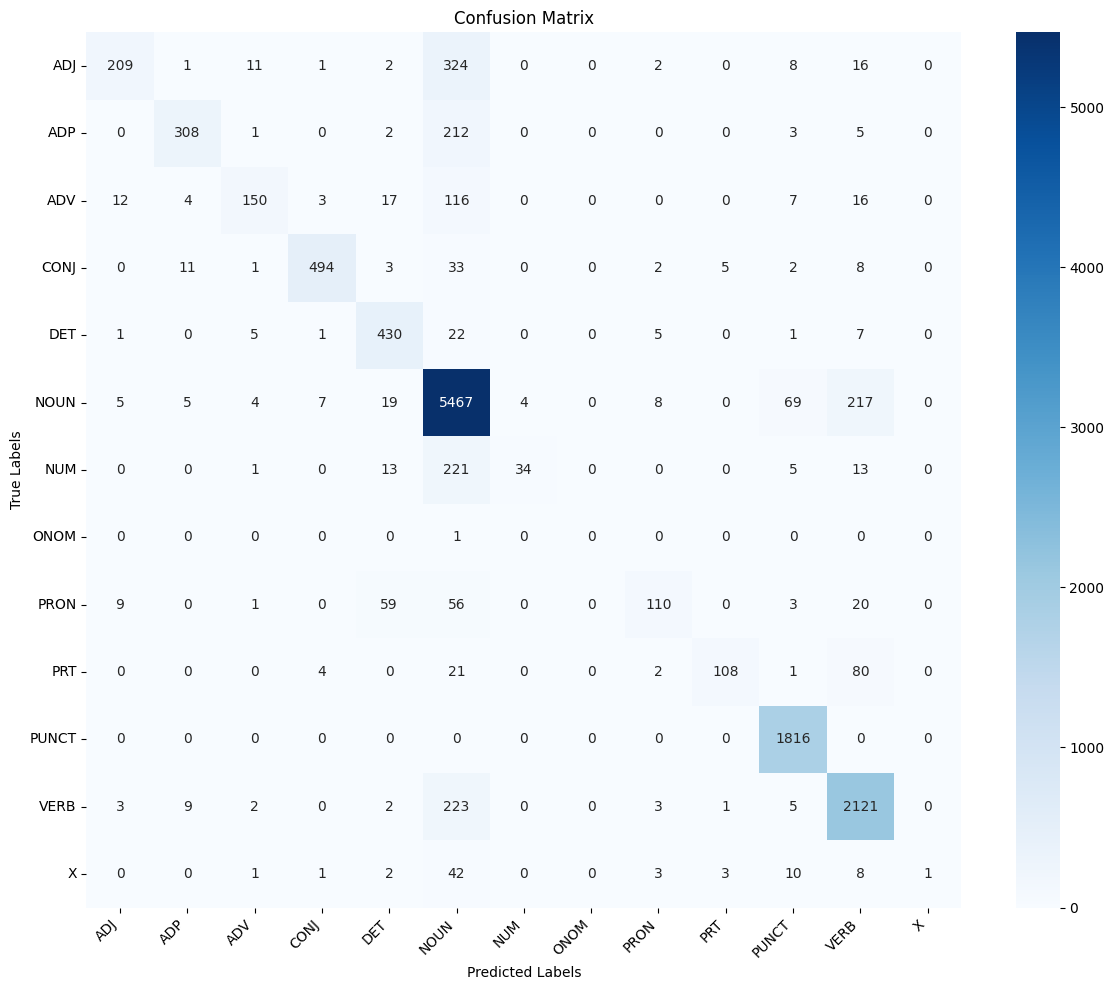


Classification Report:
              precision    recall  f1-score   support

         ADJ       0.87      0.36      0.51       574
         ADP       0.91      0.58      0.71       531
         ADV       0.85      0.46      0.60       325
        CONJ       0.97      0.88      0.92       559
         DET       0.78      0.91      0.84       472
        NOUN       0.81      0.94      0.87      5805
         NUM       0.89      0.12      0.21       287
        ONOM       0.00      0.00      0.00         1
        PRON       0.81      0.43      0.56       258
         PRT       0.92      0.50      0.65       216
       PUNCT       0.94      1.00      0.97      1816
        VERB       0.84      0.90      0.87      2369
           X       1.00      0.01      0.03        71

    accuracy                           0.85     13284
   macro avg       0.82      0.55      0.60     13284
weighted avg       0.85      0.85      0.83     13284



In [ ]:
# I train and evaluate Model 1 with all tags
print("=" * 60)
print("MODEL 1: MODEL TRAINED WITH ALL TAGS")
print("=" * 60)

#  prepare data for all tags model
prepared_train_all = prepare_data(train_sentences, all_tags_list)
prepared_test_all = prepare_data(test_sentences, all_tags_list)

num_train_all = len(prepared_train_all)
num_test_all = len(prepared_test_all)

print(f"Number of training sentences (filtered): {num_train_all}")
print(f"Number of test sentences (filtered): {num_test_all}")

#  creat HMM model with all tags
transitions_all, emissions_all, tag_counts_all, vocab_all, word_count_all = create_HMM(prepared_train_all)

print(f"\nModel 1 Evaluation:")
print("-" * 60)
#  evaluateing the model
accuracy_all, f1_macro_all, f1_weighted_all, _, _ = evaluate_model(
    prepared_test_all, transitions_all, emissions_all, tag_counts_all, vocab_all, word_count_all
)



MODEL 2: MODEL TRAINED WITH ONLY 'ADJ, ADV, NOUN, VERB, PUNCT' TAGS
Number of training sentences (filtered): 3880
Number of test sentences (filtered): 971

Model 2 Evaluation:
------------------------------------------------------------
Making predictions on test sentences...
Processed sentences: 100/971
Processed sentences: 200/971
Processed sentences: 300/971
Processed sentences: 400/971
Processed sentences: 500/971
Processed sentences: 600/971
Processed sentences: 700/971
Processed sentences: 800/971
Processed sentences: 900/971

Accuracy: 0.9056
F1 Score (Macro): 0.7828
F1 Score (Weighted): 0.8961


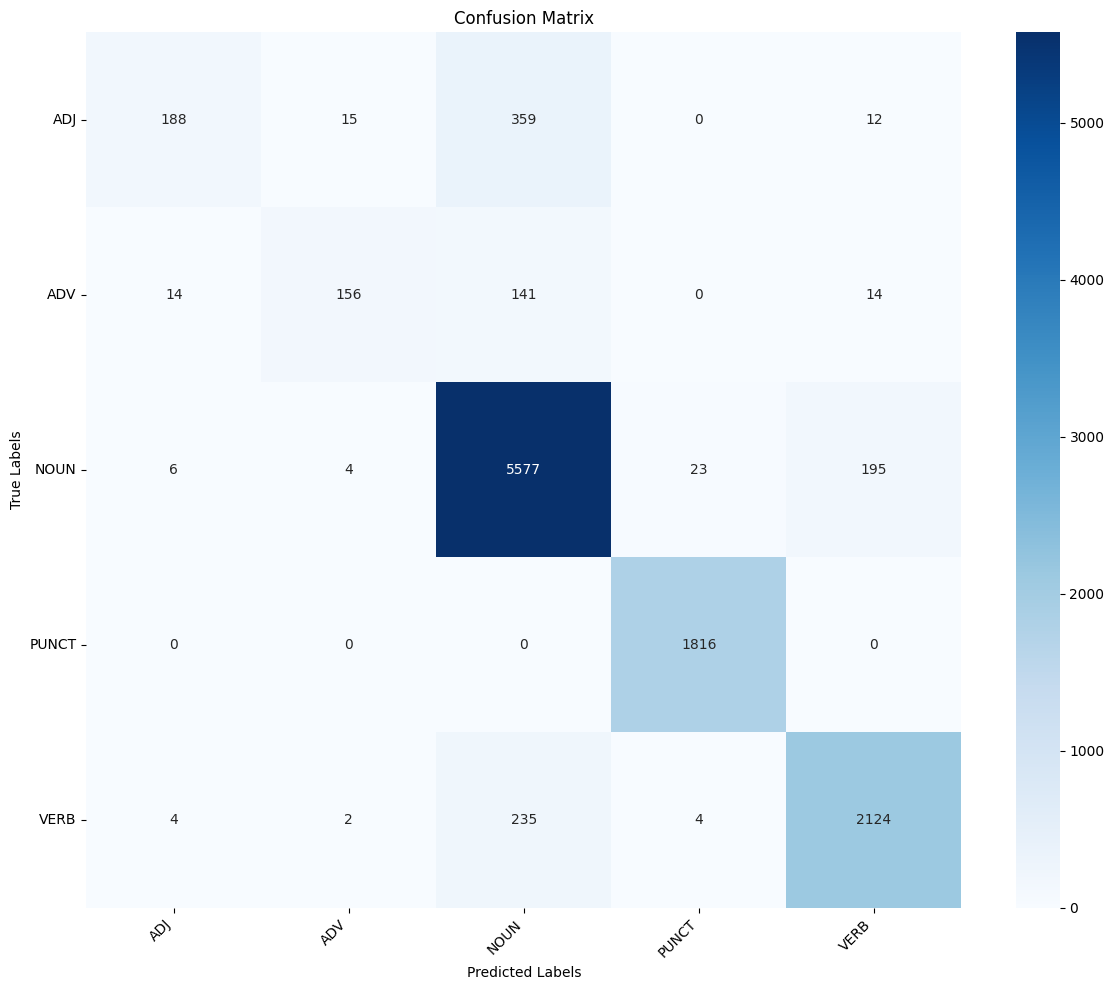


Classification Report:
              precision    recall  f1-score   support

         ADJ       0.89      0.33      0.48       574
         ADV       0.88      0.48      0.62       325
        NOUN       0.88      0.96      0.92      5805
       PUNCT       0.99      1.00      0.99      1816
        VERB       0.91      0.90      0.90      2369

    accuracy                           0.91     10889
   macro avg       0.91      0.73      0.78     10889
weighted avg       0.91      0.91      0.90     10889



In [ ]:
# I train and evaluate Model 2 with selected tags only
print("\n" + "=" * 60)
print("MODEL 2: MODEL TRAINED WITH ONLY 'ADJ, ADV, NOUN, VERB, PUNCT' TAGS")
print("=" * 60)

# prepre data for selected tags model
prepared_train_selected = prepare_data(train_sentences, selected_tags_list)
prepared_test_selected = prepare_data(test_sentences, selected_tags_list)

num_train_selected = len(prepared_train_selected)
num_test_selected = len(prepared_test_selected)

print(f"Number of training sentences (filtered): {num_train_selected}")
print(f"Number of test sentences (filtered): {num_test_selected}")

# I create HMM model with selected tags
transitions_selected, emissions_selected, tag_counts_selected, vocab_selected, word_count_selected = create_HMM(prepared_train_selected)

print(f"\nModel 2 Evaluation:")
print("-" * 60)
# evaluatd the second model
accuracy_selected, f1_macro_selected, f1_weighted_selected, _, _ = evaluate_model(
    prepared_test_selected, transitions_selected, emissions_selected, 
    tag_counts_selected, vocab_selected, word_count_selected
)


In [ ]:
# compare the two models  which one is better
print("\n" + "=" * 60)
print("MODEL COMPARISON")
print("=" * 60)

import pandas as pd

# I prepare data for comparison table (I use pandas for this)
metric_names = ['Accuracy', 'F1 Score (Macro)', 'F1 Score (Weighted)']
all_tags_values = [accuracy_all, f1_macro_all, f1_weighted_all]
selected_tags_values = [accuracy_selected, f1_macro_selected, f1_weighted_selected]

comparison_data = {
    'Metric': metric_names,
    'All Tags': all_tags_values,
    'Selected Tags (5)': selected_tags_values
}

# I create and print comparison 
comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

print("\n" + "-" * 60)
print("CONCLUSION:")
print("-" * 60)

# I compare accuracy betwen  two models
if accuracy_all > accuracy_selected:
    print(f"Model trained with all tags has higher accuracy: {accuracy_all:.4f} vs {accuracy_selected:.4f}")
else:
    print(f"Model trained with selected tags has higher accuracy: {accuracy_selected:.4f} vs {accuracy_all:.4f}")

# also compare F1 macro score to be thorough
if f1_macro_all > f1_macro_selected:
    print(f"Model trained with all tags has higher F1 (macro) score: {f1_macro_all:.4f} vs {f1_macro_selected:.4f}")
else:
    print(f"Model trained with selected tags has higher F1 (macro) score: {f1_macro_selected:.4f} vs {f1_macro_all:.4f}")



MODEL COMPARISON
             Metric  All Tags  Selected Tags (5)
           Accuracy  0.846733           0.905593
   F1 Score (Macro)  0.595561           0.782835
F1 Score (Weighted)  0.828545           0.896100

------------------------------------------------------------
CONCLUSION:
------------------------------------------------------------
Model trained with selected tags has higher accuracy: 0.9056 vs 0.8467
Model trained with selected tags has higher F1 (macro) score: 0.7828 vs 0.5956


## 6. Assignment Report

This section contains the approach, results, and evaluation of the project.


Data Preparation Method

In this project, I created the dataset by combining web.conllu and wiki.conllu files. Since both files follow the CONLL-U format, each line contains a word and its POS tag. I loaded the files using the read_conll function, removed lines starting with “#” because they only contain metadata, filtered out empty lines to keep the dataset clean. Each sentence was stored as a list of (word, POS_tag) pairs so that the structure remained consistent. After cleaning, I prepared two different versions of the dat aset: one that included all POS tags and a simplifyied version that only kept ADJ, ADV, NOUN, VERB, and PUNCT. The filtering was done through the prepare_data function, which helpd me generate both datasets in a systematic way. Finally, I performed an 80/20 train–test split using random_state=42 to ensure that the results would remain reproducable.

MLE Probability Calculation Method

For the Hidden Markov Model, I computed transition and emission probabilities using Maximum Likelihood Estimation. Transition probabilities are calculated by counting how often one tag followed another and dividing it by the total occurrences of the preceding tag. Emission probabilities were obtained by dividing how many times a word appeared with a specific tag by the total freqency of that tag. Since some word-tag combinations never appared in the training data, zero probabilities became a problem. To avoid this, I applied Laplace smoothing with α=1 so every probability would remain non-zero. I also added strat and end tokens to properly model sentence boundaries becaues predicting the beginning and end of sentences is important for HMM-based sequence tagging.

Challenges Faced

During implementation, I encountered several issues. A big one was numerical underflow in the Viterbi algorithm caused by multiplying many tiny probabilities. Switching to log-probabilities fixed this and made calculations stable. Another problem was dealing with out-of-vocabulary wordswords that never showed up in the training set. For these cases, I assigned a small but non-zero emission probability. The Turkish languge itself added complexity because of its hard nature, which produces many different word forms and greatly expands the vocabulary. This increased the number of OOV words and sometimes created  long sentences, which made the Viterbi matrix larger and slowed down computation.

Performance Comments

I evaluatead the models using accuracy and f1-score. The full-tag model had lower accuracy because it had to choose among many tags, but it provided more detailed tagging. The reduced-tag model performed better in terms of acuracy and f1-score since it had less labels to predict. The confusion matrix showed that most errors came from tags they are similar in meaning or usage.

Limitations and Possible Improvements

The current model only uses bigram dependencyies. Using trigrams could improve contextual understanding but would increase computation time. My approach to handling unknown words is simple and cann be improved using suffix information, character n-grams or pretrained word embeddings. Since Turkish is morphologically rich, adding CONLL-U features like Case or PersonNumber maybe improve performance. Other possible improvvements include trying different smoothing method or combining multiple models through ensemble techniqes.